# Aula 2 - Planejamento de Sistemas Elétricos

## PPEE - UFJF

Esta é aula 2 da disciplina de Planejamento de Sistemas Elétricos do PPEE-UFJF

O seu objetivo é apresentar uma implementação em Python da Técnica de Programação Dinâmica Estocástica "Adptada" 



## Definição dos Dados do Problema

Usinas Hidrelétricas, termelétricas e dados gerais do sistema

In [1]:
lista_uhe = []

usina = {
    "Nome": "UHE DO MARCATO", # Nome da Usina
    "Vmax": 100.,             # Volume Máximo em hm^3
    "Vmin": 20.,              # Volume Mínimo em hm^3
    "Prod": 0.95,             # Produtibilidade em MWmed/hm^3
    "Engol": 60.,             # Engolimento Máximo em hm^3
    "Afl": [                  # Cenários de Afluências (linha: Estágio, coluna: cenário)
            [ 23, 16],
            [ 19, 14],
            [ 15, 11]
    ]
}

lista_uhe.append(usina)

#
# Retirar os comentários abaixo para considerar 2 UHEs
#
#usina = {
#    "Nome": "UHE DO VASCAO",
#    "Vmax": 200.,
#    "Vmin": 40.,
#    "Prod": 0.85,
#    "Engol": 100.,
#    "Afl": [ 
#            [ 46, 32],
#            [ 38, 28],
#            [ 30, 22]
#    ]
#}
#lista_uhe.append(usina)

usina = {
    "Nome": "GT_1",     # Nome da Usina Térmica 1
    "Capac": 15.,       # Capacidade Máxima de Geração MWMed
    "Custo": 10.        # Custo de Operação $/MWMed
}

lista_ute = []

lista_ute.append(usina)

usina = {
    "Nome": "GT_2",     # Nome da Usina Térmica 2
    "Capac": 10.,       # Capacidade Máxima de Geração MWmed
    "Custo": 25.        # Custo de Operação $/MWMed
}

lista_ute.append(usina)

#
# d_gerais para o caso 1 UHE
#
d_gerais = {
    "CDef": 500.,             # Custo de Déficit $/MWMed
    "Carga": [ 50, 50., 50],  # Lista com carga a ser atendida por estágio
    "Nr_Disc": 12,            # Número de Discretizações
    "Nr_Est": 3,              # Número de Estágios
    "Nr_Cen": 2               # Número de Cenários de Afluências
}

#
# d_gerais para o caso 2 UHE (Comentar o bloco acima e descomentar o bloco abaixo)
#
#d_gerais = {
#    "CDef": 500.,
#    "Carga": [ 100, 100., 100],
#    "Nr_Disc": 3,
#    "Nr_Est": 3,
#    "Nr_Cen": 2
#}

#
# Cria dicionário de dados com todas as informações do sistema em estudo
#
sistema = {
    "DGer": d_gerais,
    "UHE": lista_uhe,
    "UTE": lista_ute
}


## Modelo de Otimização

Criação de uma Função para o Despacho Hidrotérmico

$Min \hspace{0.5cm} C_1 \cdot gt_1 + C_2 \cdot gt_2 + CDEF \cdot def + 0.01 \cdot vvert + \alpha$

sujeito a:

$ vf = VI + AFL - vtur - vvert $ (Equação de Balanço Hídrico)

$ \rho \cdot vtur + gt_1 + gt_2 + def = CARGA $ (Equação de Atendimento à Demanda)

$ 20 \le vf \le 100 $ 

$ 0 \le vtur \le 60 $

$ 0 \le vvert \le \infty $

$ 0 \le gt_1 \le 15 $

$ 0 \le gt_2 \le 10 $

$ 0 \le def \le \infty $

Inequações dos Cortes (para cada corte i)

$ \alpha \ge \sum_j{a_{ji}} \cdot {v_f}_j + b_i $

In [3]:
from cvxopt.modeling import variable, solvers
from cvxopt.modeling import op

#
# Cria função de despacho hidrotérmico
#

def despacho(sistema, VI, AFL, pote_de_corte, iest, imprime):

  Num_UHE = len(sistema["UHE"])

  Num_UTE = len(sistema["UTE"])

  #
  # Cria Variáveis de Decisão
  #

  vf = variable(Num_UHE, "Volume Final na Usina")
  vt = variable(Num_UHE, "Volume Turbinado na Usina")
  vv = variable(Num_UHE, "Volume Vertido na Usina")
  gt = variable(Num_UTE, "Geração na Usina Térmica")
  deficit = variable(1, "Déficit de Energia no Sistema")
  alpha = variable(1, "Custo Futuro")

  # Construção da Função Objetivo

  fob = 0

  for i, iusi in enumerate(sistema["UTE"]):
    fob += iusi['Custo']*gt[i]

  fob += sistema["DGer"]["CDef"]*deficit[0]

  for i, iusi in enumerate(sistema["UHE"]):
    fob += 0.01*vv[i]

  fob += 1.0*alpha[0]

  # Definição das Restrições

  restricoes = []

  # Balanço Hídrico

  for i, iusi in enumerate(sistema["UHE"]):
    restricoes.append( vf[i] == float(VI[i]) + float(AFL[i]) - vt[i] - vv[i])

  # Atendimento à Demanda

  AD = 0

  for i,usi in enumerate(sistema["UHE"]):
    AD += iusi["Prod"]*vt[i]

  for i,usi in enumerate(sistema["UTE"]):
    AD += gt[i]

  AD += deficit[0]

  restricoes.append( AD == sistema["DGer"]["Carga"][iest-2])

  # Restricoes Canalização

  for i, iusi in enumerate(sistema["UHE"]):
    restricoes.append(vf[i] >= iusi["Vmin"])
    restricoes.append(vf[i] <= iusi["Vmax"])
    restricoes.append(vt[i] >= 0)
    restricoes.append(vt[i] <= iusi["Engol"])
    restricoes.append(vv[i] >= 0)

  for i, iusi in enumerate(sistema["UTE"]):
    restricoes.append(gt[i] >= 0)
    restricoes.append(gt[i] <= iusi["Capac"])

  restricoes.append( deficit[0] >= 0)

  restricoes.append ( alpha[0] >= 0)

  #
  # Insere inequações correspondentes aos cortes
  #

  for icorte in pote_de_corte:
    if icorte['Estagio'] == iest:
      equacao = 0
      for iusi in range(Num_UHE):
        equacao += float(icorte['Coefs'][iusi])*vf[iusi]
      equacao += float(icorte['Termo_Indep'])
      restricoes.append(alpha[0] >= equacao)

  #
  # Cria problema de otimização
  #

  problema = op(fob,restricoes)

  #
  # Chama solver GLPK e resolve o problema de otimização linear
  #

  problema.solve('dense','glpk')

  #
  # Armazena resultados do problema em um dicionário de dados
  #

  Dger = {
      "Deficit": deficit[0].value()[0],
      "CMO": restricoes[Num_UHE].multiplier.value[0],
      "CustoTotal": fob.value()[0],
      "CustoFuturo": alpha[0].value()[0]
  }

  lista_uhe = []
  for i, iusi in enumerate(sistema["UHE"]):
    resultado = { 
        "vf": vf[i].value()[0],
        "vt": vt[i].value()[0],
        "vv": vv[i].value()[0],
        "cma": restricoes[i].multiplier.value[0]
                 }
    lista_uhe.append(resultado)
  
  lista_ute = []
  for i, iusi in enumerate(sistema["UTE"]):
    resultado = {
        "gt": gt[i].value()[0]
    }
    lista_ute.append(resultado)

  resultado = {
      "DGer": Dger,
      "UHE": lista_uhe,
      "UTE:": lista_ute
  }

  #
  # Imprime resultados em tela
  #

  if imprime:
    print("Custo Total:", fob.value())

    for i,usi in enumerate(sistema["UHE"]):
      print(vf.name,i,"é",vf[i].value(),"hm3")
      print(vt.name,i,"é",vt[i].value(),"hm3")
      print(vv.name,i,"é",vv[i].value(),"hm3")

    for i,usi in enumerate(sistema["UTE"]):
      print(gt.name,i,"é",gt[i].value(), "MWmed")

    print(deficit.name,"é",deficit[0].value(), "MWmed")

    print(alpha.name,"é",alpha[0].value(), "$")

    for i,iusi in enumerate(sistema["UHE"]):
      print("O valor da água na usina",i,"é: ", restricoes[i].multiplier.value )

    print("O Custo Marginal de Operação é: ", restricoes[Num_UHE].multiplier.value)

    print("----- x ------ ")

  #
  # Retorna da função exportando os resultados
  #

  return(resultado) 


## Programa Principal 

Implementa o algoritmo da PDE Adaptada

Tempo decorrido na PDE Adaptada 1.0792739391326904
Custo Total: [ 9.97e+02]

Volume Final na Usina 0 é [ 5.17e+01]
 hm3
Volume Turbinado na Usina 0 é [ 2.63e+01]
 hm3
Volume Vertido na Usina 0 é [ 0.00e+00]
 hm3
Geração na Usina Térmica 0 é [ 1.50e+01]
 MWmed
Geração na Usina Térmica 1 é [ 1.00e+01]
 MWmed
Déficit de Energia no Sistema é [ 3.55e-15]
 MWmed
Custo Futuro é [ 5.97e+02]
 $
O valor da água na usina 0 é:  [ 2.38e+01]

O Custo Marginal de Operação é:  [-2.50e+01]

----- x ------ 


{'DGer': {'Deficit': 3.552713678800501e-15,
  'CMO': -25.00000000000017,
  'CustoTotal': 996.8749999999989,
  'CustoFuturo': 596.874999999997},
 'UHE': [{'vf': 51.684210526315795,
   'vt': 26.31578947368421,
   'vv': 0.0,
   'cma': 23.750000000000124}],
 'UTE:': [{'gt': 15.0}, {'gt': 10.0}]}

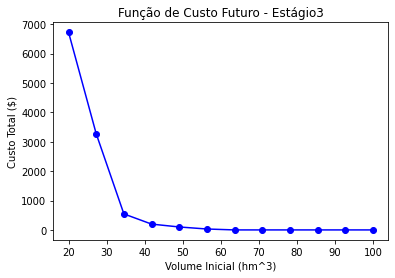

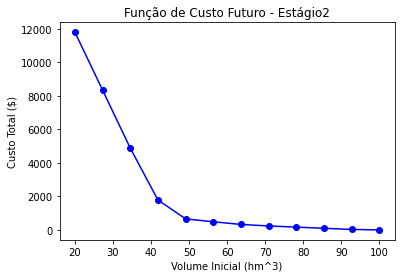

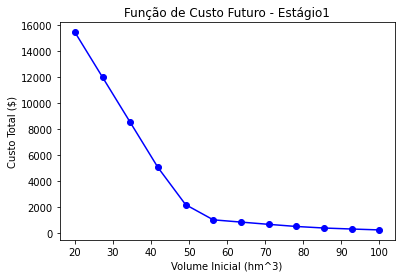

In [5]:
from itertools import product, tee
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time

Num_UHE = len(sistema["UHE"])

Num_UTE = len(sistema["UTE"])

#
# Calcula o tamanho do passo percentual (distância entre cada discretização)
#

passo = 100/(sistema["DGer"]["Nr_Disc"]-1)

#
# Calcula um iterator com todas as combinações possíveis
#

discretizacoes = product(np.arange(0,100+passo,passo), repeat = Num_UHE)

#
# Transforma o iterator em uma lista
#

discretizacoes = list(discretizacoes)

#
# Esta é uma lista com dicionários contendo todos os cortes criados
# Inicia vazia
#

pote_de_corte = []

#
# Computa o instante de tempo no qual o processo iterativo iniciou
#
t = time.time()

#
# Laço ou Loop mais externo de estágios (de trás para frente ou backward)
#
for iest in np.arange(sistema["DGer"]["Nr_Est"],0,-1):
  #
  # Se número de usinas hidrelétricas igual a um inicia a construção
  # De Gráfico Bidemensional para fcf (um para cada estágio)
  #
  if Num_UHE == 1:
    plt.figure(iest)
    plt.title("Função de Custo Futuro - Estágio"+str(iest))
    plt.xlabel("Volume Inicial (hm^3)")
    plt.ylabel("Custo Total ($)")
    eixox = []
    eixoy = []
  #
  # Se número de usinas hidrelétricas igual a dois inicia a construção
  # De Gráfico Tridimensional para fcf (um para cada estágio)
  #
  if Num_UHE == 2:
    fig = plt.figure(iest)
    ax = fig.gca(projection='3d')
    ax.set_title('Função de Custo Futuro - Estágio'+str(iest))
    ax.set_xlabel('Vol.In. UHE 1')
    ax.set_ylabel('Vol.In. UHE 2')
    ax.set_zlabel('FCF ($)')
    Usi_1 = np.arange(0,100+passo,passo)
    Usi_2 = np.arange(0,100+passo,passo)
    Usi_1, Usi_2 = np.meshgrid(Usi_1, Usi_2)
    Custos = np.zeros((sistema["DGer"]["Nr_Disc"],sistema["DGer"]["Nr_Disc"]))

  #
  # Laço ou loop intermediário (percorre todas as discretizações para cada
  # Estágio)
  #
  for discretizacao in discretizacoes:
    #
    # Conforme for a discretização calcula o VI (Volume Inicial) em hm^3
    # para cada UHE
    #
    VI = []
    for i, iusi in enumerate(sistema["UHE"]):
      VI.append(iusi["Vmin"] + (iusi["Vmax"]-iusi["Vmin"])*discretizacao[i]/100)
    if Num_UHE == 1:
      eixox.append(VI[0])
    #
    # Inicia variáveis que computarão a média da FOB e do CMA dos cenários
    #
    media = 0.
    media_cma = []
    for i, iusi in enumerate(sistema["UHE"]):
        media_cma.append(0)
    #
    # Laço ou loop mais interno. Varre todos os cenários para cada discretização
    #
    for icen in np.arange(0,sistema["DGer"]["Nr_Cen"]):
      AFL = []
      for i, iusi in enumerate(sistema["UHE"]):
        AFL.append(iusi["Afl"][iest-1][icen])
      #
      # Chama função de despacho hidrotérmico
      #
      resultado = despacho(sistema,VI,AFL,  pote_de_corte, iest+1, imprime = False)
      media += resultado["DGer"]["CustoTotal"]
      for i, iusi in enumerate(resultado["UHE"]):
        media_cma[i] += iusi["cma"]
    media = media/sistema["DGer"]["Nr_Cen"]
    if Num_UHE == 2:
      for linha in range(sistema["DGer"]["Nr_Disc"]):
        for coluna in range(sistema["DGer"]["Nr_Disc"]):
          if Usi_1[linha][coluna] == discretizacao[0] and Usi_2[linha][coluna] == discretizacao[1]:
             Custos[linha][coluna] = media
    term_indep = media
    for i, iusi in enumerate(resultado["UHE"]):
      media_cma[i] = -media_cma[i] / sistema["DGer"]["Nr_Cen"]
      term_indep -= VI[i]*media_cma[i]
    #
    # Calcula o corte (inequação) correspondente a uma discretização
    #
    corte = {
        "Estagio": iest,
        "Termo_Indep": term_indep,
        "Coefs": media_cma
    }  
    #
    # Insere o corte no final da lista pote_de_corte
    #
    pote_de_corte.append(corte)
    
    if Num_UHE == 1:
      eixoy.append(media)
  if Num_UHE == 1:
    plt.plot(eixox,eixoy,marker="o",color="blue")
  if Num_UHE == 2:
    surf = ax.plot_surface(Usi_1, Usi_2, Custos, cmap=cm.coolwarm)
#
# Calcula o tempo decorrido desde o início do algoritmo
#
print("Tempo decorrido na PDE Adaptada", time.time() - t)
#
# Resolve o problema de despacho hidrotérmico no início do estágio 1.
# Assumindo-se conhecidos os volume iniciais das UHEs e as afluências às
# UHEs no primeiro estágio
#

# Usar a linha abaixo para 1 UHE
despacho(sistema, [62], [16], pote_de_corte, 2, imprime=True)

# Usar a linha abaixo para 2 UHEs (descomentar)
#despacho(sistema, [62, 150], [16, 30], pote_de_corte, 2, imprime=True)
